In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from urllib.parse import urlparse

In [36]:
matplotlib.rcParams['font.family'] = 'Noto Serif CJK JP'
matplotlib.rcParams['axes.unicode_minus'] = False

In [37]:
df = pd.read_csv('performance_results.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,interactive,pagename,url,screenshotpath,run
0,130 ms,650 ms,1630 ms,0.231,0 ms,1622,2 KB,1095 ms,330,4024 ms,首页,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io__market_overview_run1_22-0...,7
1,475 ms,683 ms,2041 ms,0.171,0 ms,1002,0 KB,1260 ms,363,3235 ms,模型,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io__market_mw_asset_run1_22-0...,7
2,165 ms,1153 ms,2240 ms,0.321,19 ms,3668,6 KB,1076 ms,377,6003 ms,应用,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io__market_applet_run1_22-04-...,7
3,204 ms,627 ms,1824 ms,0.000,0 ms,838,0 KB,709 ms,277,1824 ms,知识,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io__market_sample_knowledge_r...,7
4,126 ms,531 ms,1666 ms,0.000,0 ms,919,0 KB,759 ms,262,1691 ms,管理中心-用户,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io__manage_center_users_run1_...,7


In [38]:
t_df = df.drop(['screenshotpath', 'run', 'url'], axis=1)
# t_df = df.columns.difference(['screenshotpath', 'url', 'run'])
t_df['host'] = df['url'].apply(lambda x: urlparse(x).netloc)
t_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,interactive,pagename,host
0,130 ms,650 ms,1630 ms,0.231,0 ms,1622,2 KB,1095 ms,330,4024 ms,首页,llmops.transwarp.io
1,475 ms,683 ms,2041 ms,0.171,0 ms,1002,0 KB,1260 ms,363,3235 ms,模型,llmops.transwarp.io
2,165 ms,1153 ms,2240 ms,0.321,19 ms,3668,6 KB,1076 ms,377,6003 ms,应用,llmops.transwarp.io
3,204 ms,627 ms,1824 ms,0.000,0 ms,838,0 KB,709 ms,277,1824 ms,知识,llmops.transwarp.io
4,126 ms,531 ms,1666 ms,0.000,0 ms,919,0 KB,759 ms,262,1691 ms,管理中心-用户,llmops.transwarp.io


In [39]:
def clean_numeric(column):
    if column.dtype == 'object':
        return pd.to_numeric(column.str.replace(r'[^\d.]+', '', regex=True))
    else:
        return column

n_df = t_df.iloc[:, :10].apply(clean_numeric)
n_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,interactive
0,130,650,1630,0.231,0,1622,2,1095,330,4024
1,475,683,2041,0.171,0,1002,0,1260,363,3235
2,165,1153,2240,0.321,19,3668,6,1076,377,6003
3,204,627,1824,0.000,0,838,0,709,277,1824
4,126,531,1666,0.000,0,919,0,759,262,1691


### 归一化

In [69]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
s_df = pd.DataFrame(
    scaler.fit_transform(n_df),
    columns=t_df.columns[0:10]
)
s_df['pagename'] = t_df['pagename']
s_df['host'] = t_df['host']
s_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,host
0,0.670717,0.797692,0.895920,0.339492,0.545455,0.628047,1.0,0.436602,0.591304,0.027108,main_page,llmops.transwarp.io
1,0.759417,0.992308,0.679629,0.956120,0.727273,0.499196,1.0,0.612742,0.917391,0.108434,model_management,llmops.transwarp.io
2,0.867558,1.000000,0.672342,0.743649,0.500000,0.688856,1.0,0.618364,1.000000,0.696386,app_management,llmops.transwarp.io
3,0.640340,0.837692,0.680472,0.247113,0.454545,0.484731,1.0,0.565896,0.739130,0.077711,corpus_text_dataset,llmops.transwarp.io
4,0.733900,0.887692,0.677865,0.184758,1.000000,0.563354,1.0,0.609619,0.760870,0.578916,knowledge_management,llmops.transwarp.io


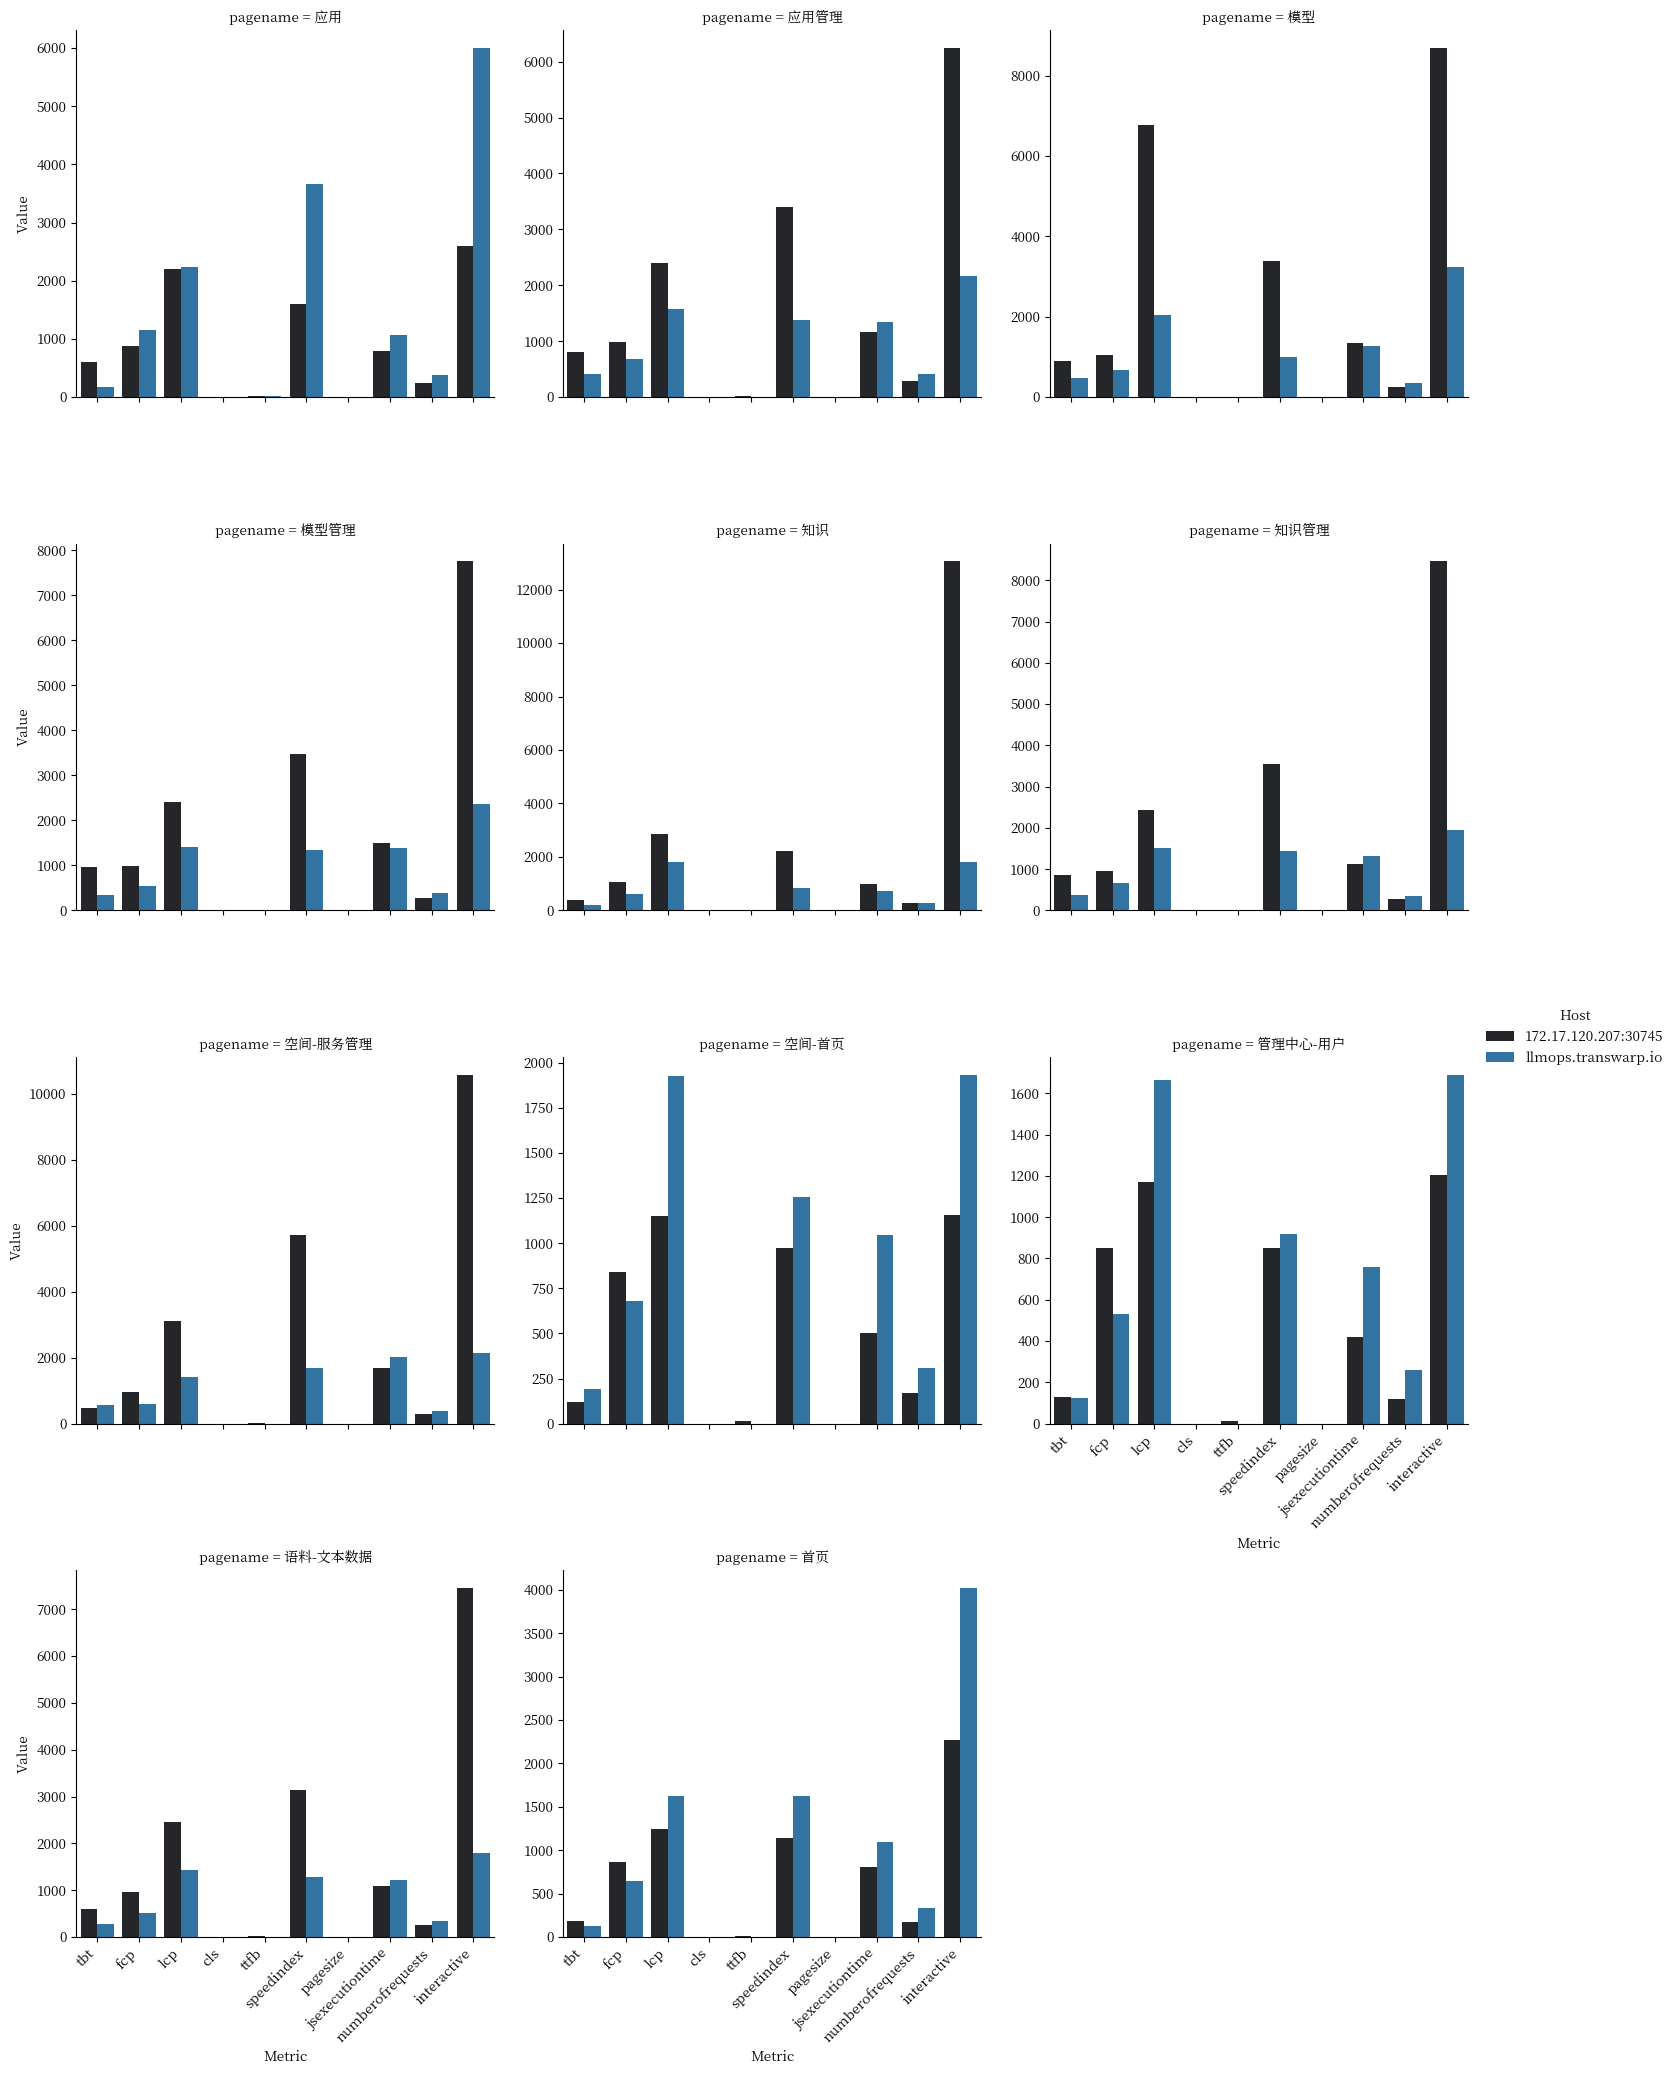

In [43]:
m_df = s_df.melt(id_vars=['pagename', 'host'], var_name='Metric', value_name='Value')
metric_order = m_df['Metric'].unique()
host_order = m_df['host'].unique()

g = sns.FacetGrid(m_df, col='pagename', col_wrap=3, sharey=False, height=5)
g.map(sns.barplot, 'Metric', 'Value', 'host', dodge=True, palette='dark:#1f77b4', order=metric_order, hue_order=host_order)

# 手动为每个子图设置 x 轴标签，只对最后三个有效, why?
for ax in g.axes.flat:
    ax.set_xticks(range(len(metric_order)))
    ax.set_xticklabels(metric_order, rotation=45, ha='right')

g.add_legend(title='Host')
plt.subplots_adjust(hspace=0.4)
plt.savefig('normalization.png', dpi=300, bbox_inches='tight')
plt.show()

### 百分比

In [71]:
s_df = pd.DataFrame(n_df, columns=t_df.columns[0:10])
s_df['pagename']= t_df['pagename']
s_df['host']= t_df['host']
s_df = s_df.sort_values(['pagename', 'host'])
s_df.head()


,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,host
9,503,1384,4102,0.255,14,5038,2,1237,296,1696,app_management,172.17.120.207:30745
2,771,2675,12853,0.322,20,7568,3,1596,406,1724,app_management,llmops.transwarp.io
10,312,1382,4096,0.000,9,4203,3,1177,267,875,corpus_text_dataset,172.17.120.207:30745
3,584,2464,12959,0.107,19,6044,3,1512,346,697,corpus_text_dataset,llmops.transwarp.io
11,493,1384,4087,0.000,11,4312,3,1223,272,1542,knowledge_management,172.17.120.207:30745


/tmp/ipykernel_3079/2057756127.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_df = s_df.groupby('pagename', group_keys=False).apply(lambda x: percentage_change(x.iloc[:, :10]))


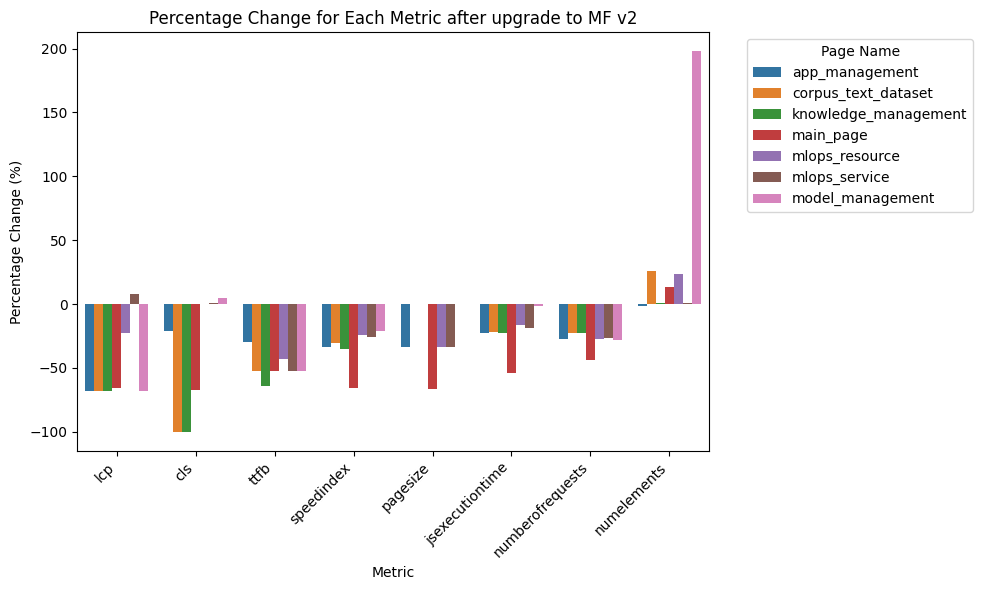

In [75]:
def percentage_change(df):
    row1, row2 = df.iloc[0], df.iloc[1]
    change = (row1 - row2) / row2.replace(0, 1) * 100
    return pd.Series(change, index=df.columns[2:])

g_df = s_df.groupby('pagename', group_keys=False).apply(lambda x: percentage_change(x.iloc[:, :10]))

m_df = g_df.reset_index().melt(id_vars='pagename', var_name='Metric', value_name='PercentageChange')
plt.figure(figsize=(10, 6))
sns.barplot(data=m_df, x='Metric', y='PercentageChange', hue='pagename')

plt.title('Percentage Change for Each Metric after upgrade to MF v2')
plt.ylabel('Percentage Change (%)')
plt.xlabel('Metric')
plt.xticks(rotation=45, ha='right')

plt.legend(title='Page Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('percentage_change_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### 指标维度

In [40]:
s_df = pd.DataFrame(n_df, columns=t_df.columns[0:10])
s_df['pagename']= t_df['pagename']
s_df['host']= t_df['host']
s_df = s_df.sort_values(['pagename', 'host'])
s_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,interactive,pagename,host
13,608,877,2198,0.101,12,1604,0,788,242,2591,应用,172.17.120.207:30745
2,165,1153,2240,0.321,19,3668,6,1076,377,6003,应用,llmops.transwarp.io
18,813,979,2402,0.255,11,3399,1,1159,294,6246,应用管理,172.17.120.207:30745
7,417,685,1567,0.278,0,1374,0,1348,405,2169,应用管理,llmops.transwarp.io
12,892,1044,6777,0.067,10,3379,2,1353,250,8694,模型,172.17.120.207:30745


In [56]:
m_df = s_df.melt(id_vars=['pagename', 'host'], var_name='Metric', value_name='Value')
m_df.head()

,pagename,host,Metric,Value
0,应用,172.17.120.207:30745,tbt,608.0
1,应用,llmops.transwarp.io,tbt,165.0
2,应用管理,172.17.120.207:30745,tbt,813.0
3,应用管理,llmops.transwarp.io,tbt,417.0
4,模型,172.17.120.207:30745,tbt,892.0


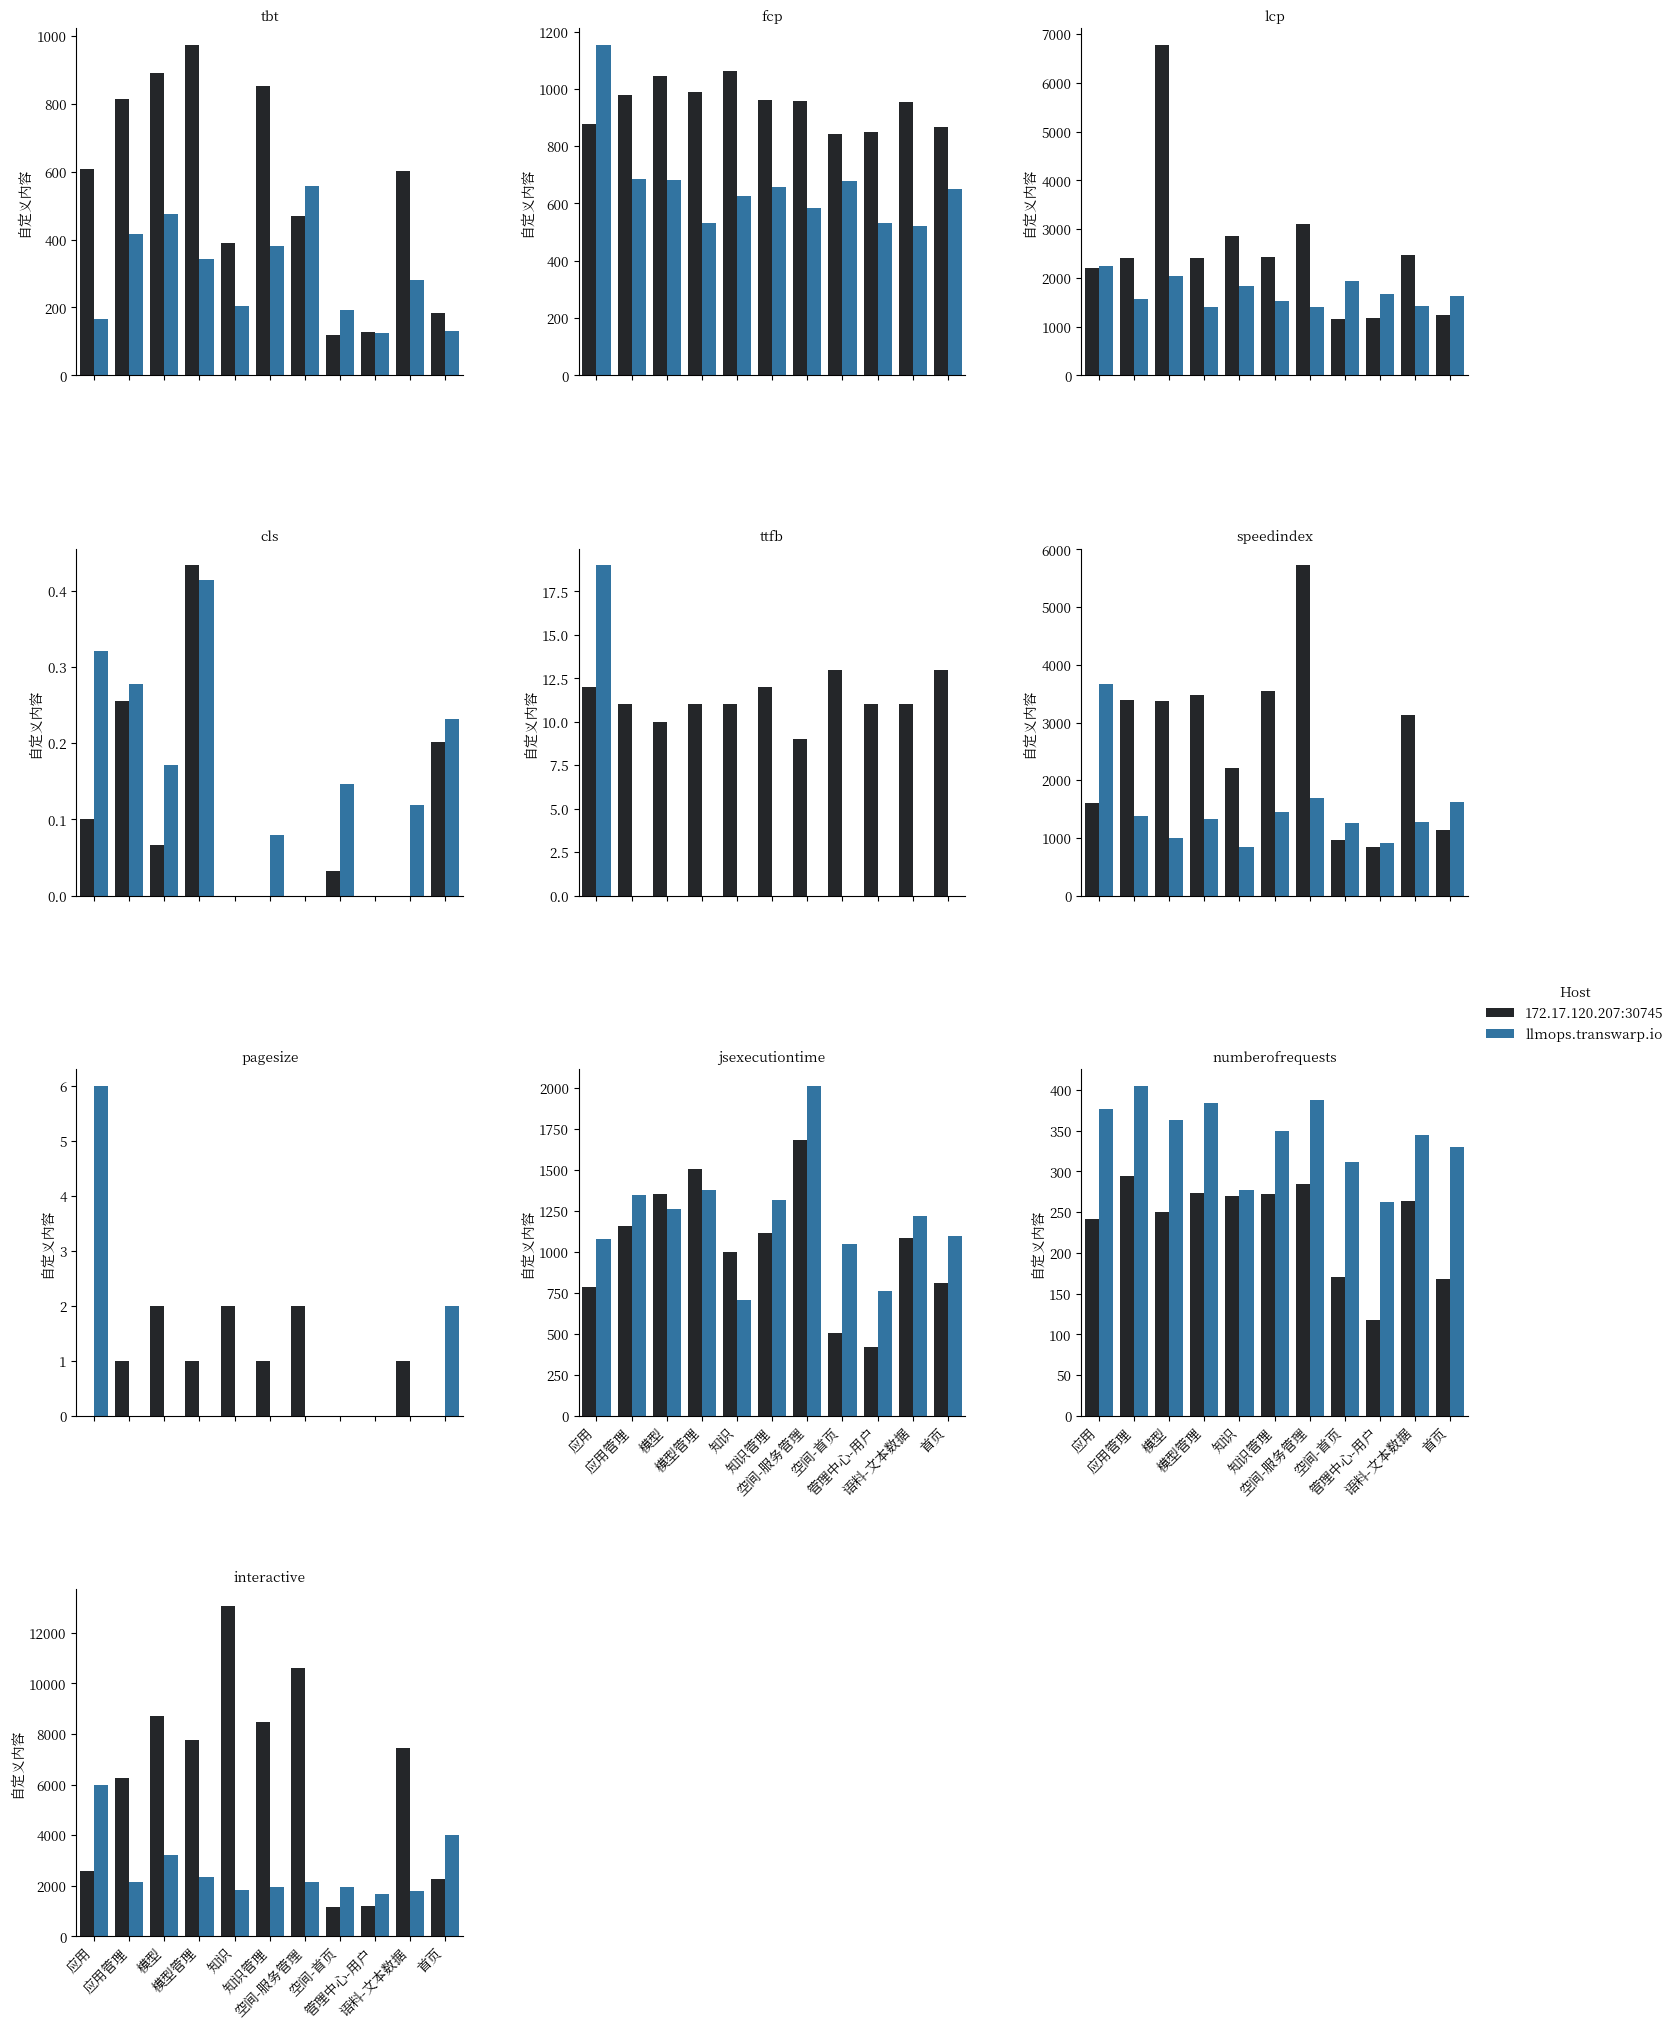

In [78]:
g = sns.FacetGrid(m_df, col='Metric', col_wrap=3, palette='dark:#1f77b4', sharey=False, height=5)
g.map_dataframe(sns.barplot, x='pagename', y='Value', hue='host', dodge=True, palette='dark:#1f77b4')

g.set_titles("{col_name}")

for ax in g.axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("自定义内容")
    ax.set_xticks(range(len(m_df['pagename'].unique())))
    ax.set_xticklabels(m_df['pagename'].unique(), rotation=45, ha='right')
    for label in ax.get_xticklabels():
        label.set_visible(True)

g.figure.subplots_adjust(hspace=0.5, wspace=0.3)
g.add_legend(title='Host')
plt.show()
# plt.savefig('grouped_barplots.png', dpi=300, bbox_inches='tight')